# GPU


```
numba.cuda # под NVIDIA
#rocm для AMD
#универсальная вещь - OpenCL
```

```
from numba.cuda import jit
```

Но есть нюансы . Как работает акселлератор? Из чего состоит GPU?

В нём есть:

А. RAM (видеопамять). Она быстрее обычной RAM (есть поколения GDDR6)

B. Процессоры: Computation Unit. Которые могут считать независимо. Можем делать параллельно. Их тысячи, а то и десятки.

```
@jit
def compute(a, b): #массив, в который передаём результат, надо записать в аргументы, как такового return для cuda нет
  i = nb.cuda.grid(1) #можно вызвать только внутри ядра
  b[i] = 2 * a[i]

```
Посчитаем на чём-нибудь, при этом решётку надо прописать явно
```
a = np.arange(1000000)
b = np.empty_like(a)
compute[(1000000)](a, b) #этот миллион и определяет размер решётки. Он должен соответствовать размеру массива
```
i у нас пробегает трёхмерную решётку в общем случае (узлы решётки), потому что так GPU устроен

Для нашего случая подойдёт одномерная решётка, тогда $i \in \left[ 0, \dots, 999999 \right]$

Решётки не могут создаваться любых размеров. Они кратны какому-то число (вроде как 32). То есть если массив будет поменьше решётки, то не пойми что будет писаться в полезную память. Нужно сделать проверку
```
@jit
def compute(a, b): 
  i = nb.cuda.grid(1)
  if i < a.shape[0]:
    b[i] = 2 * a[i]

```
Принципиальный ограничений на решётку (кроме размеров) нет.

## Память акселлератора

Есть память для констант (VRAM)

Есть память, специфичная для каждого ядра (кэш), но есть и общий кэш.

Хотим ещё иерархию памяти, которая будет медленнее, но хранить больше. Общая для рабочей группы (WG)

Поэтому в compute надо подавать ещё память для рабочей группы. А сколько памяти на самом деле мы используем?

```
@jit
def compute(a, b): 
  i = nb.cuda.grid(1)
  if i < a.shape[0]:
    b[i] = 2 * a[i]

a = np.arange(1000000)
b = np.empty_like(a)
compute[(1000000), (2 ** 16) / 32](a, b) #2 в какой-то степени и ещё надо поделить на размер варпа
```

Сама сетка будет с клетками размера WG

Попробуем сложить два массива

In [1]:
import numba.cuda as cuda
from numba.cuda import jit 
import numpy as np

In [2]:
N = 2 ** 14
a = np.random.random((N, N))
b = np.random.random((N, N))
c = np.empty_like(a)

In [3]:
@cuda.jit('(float64[:, :], float64[:, :], float64[:, :])')
def add(a, b, c):
  ix, iy = cuda.grid(2)
  if ix < a.shape[0] and iy < a.shape[1]:
    c[ix, iy] = a[ix, iy] + b[ix, iy]

In [ ]:
add[(N, N), (2 ** 5, 2 ** 5)](a, b, c)

# Свёртки. Оператор Лапласа

$\left( \Delta f \right)_k = \dfrac{f(k + 1) - 2f(k) + f(k - 1)}{\delta^2}$

In [4]:
@cuda.jit
def laplace(f, l):
  k = cuda.grid(1)
  if 1 <= k < f.shape[0]:
    l[k] = f[k + 1] - 2 * f[k] + f[k - 1] #есть проблема перечитывания данных, мы должны выделить общую память, для перекрывающихся f[k]

Как выглядит Grid:

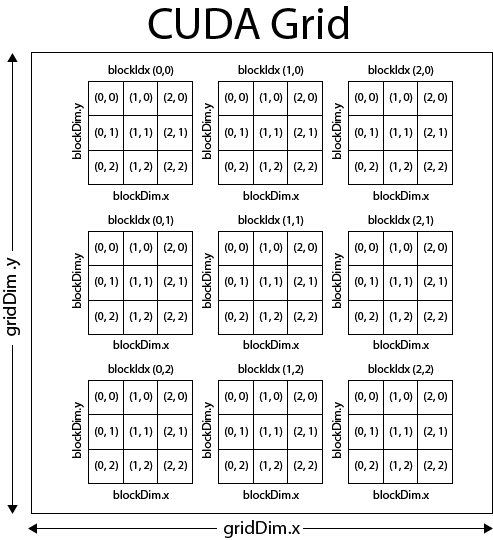

Если хотим так сгрупировать, то будут такие блоки:

block = 0: $[l_1 \; l_2]$ у каждого l будут индексы ith=0,1 

block = 1: $[l_3 \; l_4]$

Пронумеруем индексы

In [6]:
@cuda.jit
def laplace(f, l):
  ith = cuda.threadIdx(1)
  ib = cuda.blockIdx(1)
  ig = ib * cuda.blockDim.x + ith #также это делает cuda.grid(1)
  k = cuda.grid(1)
  c = cuda.shared.array(32) #создаётся массив в общей памяти для wg
  c[ith] = f[ig] #записываем в кэш
  cuda.syncthreads() #потоки начнут работать одновременно и можно быть спокойным, что всё запишется
  l[ig] = - 2 * [ith] + c [ith + 1] + c[ith - 1]